# 컨볼루션 인공신경망 Convolutional Neural Network
- MNIST 데이터
- 합성곱 연산(CNN) 
- 맥스풀링(Max Pooling)
- 완전연결 신경망(Fully Connected Network)

In [1]:
# 파이토치 및 토치비젼 설치
# 런타임을 GPU 모드로 바꿔서 실행하세요
!pip install torch torchvision

## 1. 학습전 세팅
### 1) 필요한 라이브러리 불러오기

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init

# https://pytorch.org/docs/stable/torchvision/datasets.html
# 파이토치에서는 torchvision.datasets에 MNIST 등의 다양한 데이터를 사용하기 용이하게 정리해놨습니다.
# 이를 사용하면 데이터를 따로 학습에 맞게 정리하거나 하지 않아도 바로 사용이 가능합니다.
import torchvision.datasets as datasets

# https://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transforms
# torchvision.transforms에는 이미지 데이터를 자르거나 확대 및 다양하게 변형시키는 함수들이 구현되어 있습니다. 
import torchvision.transforms as transforms

# https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader
# DataLoader는 전처리가 끝난 데이터들을 지정한 배치 크기에 맞게 모아서 전달해주는 역할을 합니다.
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

print(torch.__version__)

1.10.0+cu102


### 2) 하이퍼파라미터 지정

In [3]:
batch_size = 256
learning_rate = 0.0002
num_epoch = 100

## 2. 데이터

### 1) 데이터 다운로드

In [4]:
# https://pytorch.org/docs/stable/torchvision/datasets.html?highlight=mnist#torchvision.datasets.MNIST
# 첫번째 인자 root는 데이터를 저장할 위치, train은 학습용 데이터인지 테스트용 데이터인지의 여부를 의미합니다.

# MNIST 데이터는 숫자 손글씨 이미지와 이에 대한 정답 쌍으로 이루어져 있습니다. 
# transform은 이미지에 대한 변형, target_transform은 정답 라벨에 대한 변형을 의미합니다.
# transform.ToTensor()는 PIL 이미지나 Numpy 배열을 토치 텐서로 바꿔줍니다.

# download는 데이터가 저장할 위치에 없을 경우 새로 다운받을지 여부입니다.
mnist_train = datasets.MNIST(root="../Data/", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = datasets.MNIST(root="../Data/", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

### 2) 데이터셋 체크
- getitem을 사용해도 되고 
- 인덱싱으로도 데이터를 확인할 수 있습니다.

In [5]:
print(mnist_train.__getitem__(0)[0].size(), mnist_train.__len__())
print(mnist_test.__getitem__(0)[0].size(), mnist_test.__len__())

print(len(mnist_train),len(mnist_test))
#print(mnist_train[0])

torch.Size([1, 28, 28]) 60000
torch.Size([1, 28, 28]) 10000
60000 10000


### 3) DataLoader 설정
- 사용할 데이터
- 배치 사이즈 (batch_size)
- 섞을지 여부 (shuffle)
- 사용할 프로세스 개수 (num_workers)
- 마지막에 남는 데이터의 처리 여부 (drop_last)

In [6]:
# https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader

train_loader = DataLoader(mnist_train,batch_size=batch_size, shuffle=True,num_workers=2,drop_last=True)
test_loader = DataLoader(mnist_test,batch_size=batch_size, shuffle=False,num_workers=2,drop_last=True)

## 3. 모델, 손실함수, 최적화함수

### 1) CNN 모델


In [7]:
# https://pytorch.org/docs/stable/nn.html?highlight=conv2d#torch.nn.Conv2d
# https://pytorch.org/docs/stable/tensors.html?highlight=view#torch.Tensor.view


class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=16,kernel_size=5),             # [batch_size,1,28,28] -> [batch_size,16,24,24]
            nn.ReLU(),                                                          # 필터의 개수는 1개(흑백이미지)에서 16개로 늘어나도록 임의로 설정했습니다. 
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=5),            # [batch_size,16,24,24] -> [batch_size,32,20,20]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),                               # [batch_size,32,20,20] -> [batch_size,32,10,10]
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),          # [batch_size,32,10,10] -> [batch_size,64,6,6]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)                                # [batch_size,64,6,6] -> [batch_size,64,3,3]
        )
        self.fc_layer = nn.Sequential(                                          
            nn.Linear(64*3*3,100),                                              # [batch_size,64*3*3] -> [batch_size,100]
            nn.ReLU(),
            nn.Linear(100,10)                                                   # [batch_size,100] -> [batch_size,10]
        )       
        
    def forward(self,x):
        out = self.layer(x)                                                     # self.layer에 정의한 Sequential의 연산을 차례대로 다 실행합니다.
        out = out.view(batch_size,-1)                                           # view 함수를 이용해 텐서의 형태를 [batch_size,나머지]로 바꿔줍니다. 
                                                                                # ex) 2x3 형태였던 텐서를 .view(1,-1) 해주면 1x6의 형태로 바뀝니다. .view(3,-1)이면 3x2로 바뀜.
                                                                                # 만약 전체 텐서의 크기가 batch_size로 나누어 떨어지지 않으면 오류가 납니다.
        out = self.fc_layer(out)
        return out

### 2) 손실함수 & 최적화함수

In [8]:
# gpu가 사용 가능한 경우에는 device를 gpu로 설정하고 불가능하면 cpu로 설정합니다.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# 모델을 지정한 장치로 올립니다.
model = CNN().to(device)

# 손실함수로는 크로스엔트로피를 사용합니다.
loss_func = nn.CrossEntropyLoss()

# 최적화함수로는 Adam을 사용합니다.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

cuda:0


## 4. 학습 

In [9]:
loss_arr =[]
for i in range(num_epoch):
    for j,[image,label] in enumerate(train_loader):
        x = image.to(device)
        y= label.to(device)
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,y)
        loss.backward()
        optimizer.step()
        
        if j % 1000 == 0:
            print(loss)
            loss_arr.append(loss.cpu().detach().numpy())

tensor(2.3025, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.2765, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1810, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1099, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0885, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0458, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0370, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0292, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0294, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0467, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0163, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0140, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0151, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0444, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0452, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0304, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0080, device='cuda:0', grad_fn=

In [10]:
param_list = list(model.parameters())
print(param_list)

[Parameter containing:
tensor([[[[ 8.5624e-02, -1.5544e-01,  2.2080e-02,  3.4878e-02, -2.9114e-02],
          [-1.6463e-01,  2.5715e-02,  2.3541e-01,  1.9484e-01,  8.1691e-02],
          [-1.0124e-01,  5.3128e-02,  3.4153e-01, -4.0516e-02, -1.2668e-01],
          [-1.6179e-01,  6.5968e-02,  1.7428e-01,  2.6017e-01, -9.1968e-02],
          [ 2.2292e-02,  5.6157e-03,  2.4056e-01,  6.8964e-02,  7.9093e-02]]],


        [[[ 1.2565e-01,  2.2122e-01,  2.9440e-01,  8.6987e-02,  1.6383e-01],
          [-1.0696e-01, -1.1849e-01,  2.1616e-01,  1.6194e-01,  1.6694e-01],
          [-2.5108e-01, -2.5563e-01, -1.5059e-01, -5.5951e-02,  3.1394e-02],
          [ 1.3788e-01,  1.5038e-01, -1.4085e-01, -2.3831e-01, -1.1747e-01],
          [-1.0675e-01,  2.0971e-01,  2.0614e-01, -6.3806e-03, -1.0354e-01]]],


        [[[-8.9195e-02,  2.9787e-01,  1.7581e-01, -1.9706e-01,  1.6444e-01],
          [ 1.3082e-01,  1.2503e-02, -1.6031e-03,  1.2873e-02,  1.8052e-01],
          [ 1.1972e-01, -9.2806e-02,  8.7611e

## 5. 학습시 손실 시각화

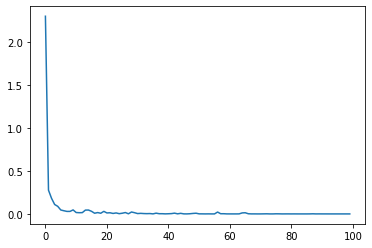

In [11]:
plt.plot(loss_arr)
plt.show()

## 6. 테스트 데이터 정확도 측정

In [12]:
# 맞은 개수, 전체 개수를 저장할 변수를 지정합니다.
correct = 0
total = 0

model.eval()

# 인퍼런스 모드를 위해 no_grad 해줍니다.
with torch.no_grad():
    # 테스트로더에서 이미지와 정답을 불러옵니다.
    for image,label in test_loader:
        
        # 두 데이터 모두 장치에 올립니다.
        x = image.to(device)
        y= label.to(device)

        # 모델에 데이터를 넣고 결과값을 얻습니다.
        output = model.forward(x)
        
        # https://pytorch.org/docs/stable/torch.html?highlight=max#torch.max
        # torch.max를 이용해 최대 값 및 최대값 인덱스를 뽑아냅니다.
        # 여기서는 최대값은 필요없기 때문에 인덱스만 사용합니다.
        _,output_index = torch.max(output,1)
        #print(len(_), _) #values
        #print(len(output_index), output_index) #indices
        
        # 전체 개수는 라벨의 개수로 더해줍니다.
        # 전체 개수를 알고 있음에도 이렇게 하는 이유는 batch_size, drop_last의 영향으로 몇몇 데이터가 잘릴수도 있기 때문입니다.
        total += label.size(0)
        
        # 모델의 결과의 최대값 인덱스와 라벨이 일치하는 개수를 correct에 더해줍니다.
        correct += (output_index == y).sum().float()
    
    # 테스트 데이터 전체에 대해 위의 작업을 시행한 후 정확도를 구해줍니다.
    print("Accuracy of Test Data: {}%".format(100*correct/total))

Accuracy of Test Data: 99.07852935791016%
